# Model Selection
Now that we've implemented user-based collaborative filtering (UBCF), and both a self-implemented SVD model as well as the SVD model from `surprise`, we can finally compare the models across the board. As we saw from the previous notebooks, user-based CF performs much worse than either SVD 

In [1]:
%%capture
import sys
import os

# Add project root to Python path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
# import packages
from utils.imports import *
# import user-defined funcs and classes
from utils.helpers import *
from models.UserBasedCF import UserBasedCF
from models.ManualSVD import ManualSVD

In [2]:
# import pandas dataframes
with open("../data/dataframes.pkl", "rb") as f:
    data = pickle.load(f)

train = data["train"]
validation = data["validation"]
baseline = data["baseline"]

# load sparse matrix
ui_csr = load_npz("../data/ui_csr.npz")

# load encodings
with open("../artifacts/user_encoder.pkl", "rb") as f:
    user_encoder = pickle.load(f)
with open("../artifacts/item_encoder.pkl", "rb") as f:
    item_encoder = pickle.load(f)
with open("../artifacts/user_map.pkl", "rb") as f:
    user_map = pickle.load(f)
with open("../artifacts/item_map.pkl", "rb") as f:
    item_map = pickle.load(f)

# load user CF
with open("../artifacts/user_CF.pkl", "rb") as f:
    user_CF = pickle.load(f)

# load user SVD models/data
with open("../artifacts/models.pkl", "rb") as f:
    models = pickle.load(f)
with open("../data/grid_search.pkl", "rb") as f:
    grid_search = pickle.load(f)

# load surprise models/data
with open("../artifacts/surprise_models.pkl", "rb") as f:
    surprise_models = pickle.load(f)
with open("../data/surprise_grid_search.pkl", "rb") as f:
    surprise_grid_search = pickle.load(f)  


## Training/Validation Performance (candidate model selection)
### User-Based CF
#### Prediction Accuracy Metrics
Now we'll evaluate user-based CF over different choices of k.

In [3]:
# let's experiment with different values of k
k_values = [3, 5, 10, 20, 50, 100]
for k in k_values:
    RMSE, MAE = user_CF.evaluate_error(validation, k)
    print(f'The RMSE for user-based CF with {k}-NN is '
          f'{RMSE}')
    print(f'The MAE for user-based CF with {k}-NN is '
          f'{MAE}')
    print('\n')

The RMSE for user-based CF with 3-NN is 0.8281375351604974
The MAE for user-based CF with 3-NN is 0.6062849787578912


The RMSE for user-based CF with 5-NN is 0.7948962457823016
The MAE for user-based CF with 5-NN is 0.5767247519566189


The RMSE for user-based CF with 10-NN is 0.7731675049216724
The MAE for user-based CF with 10-NN is 0.555877013054669


The RMSE for user-based CF with 20-NN is 0.766080997095158
The MAE for user-based CF with 20-NN is 0.5465076312264295


The RMSE for user-based CF with 50-NN is 0.7604301674859361
The MAE for user-based CF with 50-NN is 0.5415636400772108


The RMSE for user-based CF with 100-NN is 0.7582446812298936
The MAE for user-based CF with 100-NN is 0.5399732653019377




#### Top-N Predictions/Coverage
We're not only interested in prediction accuracy; we'd also like to know how effective our algorithm is at predicting novel or less popular items. To measure this, we'll look at the top-N items as calculated by taking the $N$ items for a user with the highest predicted ratings. To avoid interminable runtime, we'll use a a fast matrix-based function which precomputes the most similar neighbours for each user (not for a user-item pair).


In [4]:
k_values = [3, 5, 10, 20]
N = 10

for k in k_values:
    cov = user_CF.coverage_at_N(k, N)
    print(f'For k = {k} nearest neighbours and top-{N} beers recommended:')
    print(f'The number of recommended beers over all users is {cov[1]}')
    print(f'This corresponds to {cov[0]}% '
        'of all beers in the training matrix.\n')

For k = 3 nearest neighbours and top-10 beers recommended:
The number of recommended beers over all users is 6497
This corresponds to 24.88% of all beers in the training matrix.

For k = 5 nearest neighbours and top-10 beers recommended:
The number of recommended beers over all users is 6128
This corresponds to 23.47% of all beers in the training matrix.

For k = 10 nearest neighbours and top-10 beers recommended:
The number of recommended beers over all users is 5035
This corresponds to 19.28% of all beers in the training matrix.

For k = 20 nearest neighbours and top-10 beers recommended:
The number of recommended beers over all users is 3814
This corresponds to 14.61% of all beers in the training matrix.



It's worth mentioning that this experiment does not tell the entire story when it comes to recommending items from a catalog. This simple user-based CF model is only capable of recommending beers which have been reviewed at least three times - this already excludes the many beers which have only been reviewed once or twice. This is in addition to the fact that the system is only likely to recommend a fraction of the total available beers as demonstrated by the above code. We can investigate how recommendations differ given different neighbourhood sizes.

In [5]:
# set params
user, k, N = 69, 3, 10
get_beer_data(baseline, user_CF.top_N_beers(user, k, N))

beer_name  \
                                                         
beer_beerid                                              
276                             Sierra Nevada Pale Ale   
665                                 Anchor Liberty Ale   
3842                            Trappistes Rochefort 6   
21505                               Lammin Kataja Olut   
21519                            Smoky Mountain Porter   
21498        Dog & Pony Double Dry-hopped Imperial IPA   
21502                                 Dusty Trail Pale   
21499                                            Julöl   
21515                                  Haake Beck Pils   
21514                                 Premium Pilsener   

                                 brewery_name                      beer_style  \
                                                                                
beer_beerid                                                                     
276                 Sierra Nevada Brewing Co.         American Pale Ale (APA)   
665                    Anchor Brewing Company         American Pale Ale (APA)   
3842                   Brasserie de Rochefort         Belgian Strong Dark Ale   
21505                         Lammin Sahti Oy                           Sahti   
21519        Natty Greene's Pub & Brewing Co.                 American Porter   
21498        Maritime Pacific Brewing Company  American Double / Imperial IPA   
21502                         Amnesia Brewing         American Pale Ale (APA)   
21499                     Grebbestad Bryggeri                    Vienna Lager   
21515                     Brauerei Beck & Co.                 German Pilsener   
21514                Brauerei Herrenhausen KG                 German Pilsener   

            review_overall                 beer_abv  
                      mean count       std     mean  
beer_beerid                                          
276               4.248130  2406  0.529726      5.6  
665               4.096070  1374  0.540642      6.0  
3842              4.138889   756  0.511350      7.5  
21505             3.150485   103  0.756783      7.0  
21519             4.208333    12  0.257464      5.1  
21498             3.900000     5  0.223607      7.5  
21502             3.300000     5  0.670820      5.2  
21499             3.625000     4  0.478714      5.3  
21515             3.250000     4  0.645497      4.9  
21514             3.500000     3  0.000000      4.9

In [6]:
# set params
user, k, N = 69, 20, 10
get_beer_data(baseline, user_CF.top_N_beers(user, k, N))

beer_name  \
                                                
beer_beerid                                     
1093                          Two Hearted Ale   
276                    Sierra Nevada Pale Ale   
14916                              Hop Wallop   
1118                          Chocolate Stout   
18862                            Burton Baton   
6947         Cuvée Van De Keizer Blauw (Blue)   
2233                        Summit Winter Ale   
3646                  Urthel Hibernus Quentum   
27265                       Bell's Wheat Love   
35405              Victor's MemoriAle Altbier   

                                brewery_name                      beer_style  \
                                                                               
beer_beerid                                                                    
1093                    Bell's Brewery, Inc.                    American IPA   
276                Sierra Nevada Brewing Co.         American Pale Ale (APA)   
14916                Victory Brewing Company  American Double / Imperial IPA   
1118                              Rogue Ales                  American Stout   
18862                   Dogfish Head Brewery  American Double / Imperial IPA   
6947                     Brouwerij Het Anker         Belgian Strong Dark Ale   
2233                  Summit Brewing Company                   Winter Warmer   
3646         De Leyerth Brouwerijen (Urthel)                          Tripel   
27265                   Bell's Brewery, Inc.                       Wheatwine   
35405           Two Brothers Brewing Company                         Altbier   

            review_overall                 beer_abv  
                      mean count       std     mean  
beer_beerid                                          
1093              4.320482  2529  0.506680      7.0  
276               4.248130  2406  0.529726      5.6  
14916             3.987629  1738  0.606045      8.5  
1118              4.115407  1733  0.592690      6.0  
18862             4.010145  1380  0.557992     10.0  
6947              4.145920   723  0.594126     11.0  
2233              3.791489   235  0.494772      6.1  
3646              4.038462   221  0.543236      9.0  
27265             3.983553   152  0.547171      7.7  
35405             4.095238    42  0.508922      7.8

In [7]:
# set params
user, k, N = 420, 3, 10
get_beer_data(baseline, user_CF.top_N_beers(user, k, N))

beer_name  \
                                                    
beer_beerid                                         
226          Great Lakes Edmund Fitzgerald Porter   
142                          Ommegang (Abbey Ale)   
1385                             Delirium Tremens   
228                   Great Lakes Dortmunder Gold   
760             Weihenstephaner Kristallweissbier   
773                                    Goudenband   
62328                Estate Homegrown Wet Hop Ale   
38366                   Samuel Adams Dunkelweizen   
67262                     Longshot Blackened Hops   
67267                      Longshot Friar Hop Ale   

                                        brewery_name  \
                                                       
beer_beerid                                            
226                      Great Lakes Brewing Company   
142                                 Brewery Ommegang   
1385                                Brouwerij Huyghe   
228                      Great Lakes Brewing Company   
760          Bayerische Staatsbrauerei Weihenstephan   
773                               Brouwerij Liefmans   
62328                      Sierra Nevada Brewing Co.   
38366             Boston Beer Company (Samuel Adams)   
67262             Boston Beer Company (Samuel Adams)   
67267             Boston Beer Company (Samuel Adams)   

                            beer_style review_overall                 beer_abv  
                                                 mean count       std     mean  
beer_beerid                                                                     
226                    American Porter       4.322813  1600  0.466191      5.8  
142                             Dubbel       4.040414  1497  0.591441      8.5  
1385           Belgian Strong Pale Ale       4.022912  1353  0.589786      8.5  
228          Dortmunder / Export Lager       4.290899   868  0.499479      5.8  
760                      Kristalweizen       4.168576   611  0.512366      5.4  
773                 Flanders Oud Bruin       4.133333   465  0.576541      8.0  
62328                     American IPA       4.134085   399  0.441493      6.7  
38366                     Dunkelweizen       3.680000   275  0.553159      5.1  
67262               American Black Ale       3.924731   186  0.467577      7.0  
67267                      Belgian IPA       3.591892   185  0.561141      9.0

In [8]:
# set params
user, k, N = 420, 20, 10
get_beer_data(baseline, user_CF.top_N_beers(user, k, N))

beer_name  \
                                                        
beer_beerid                                             
131                     Ayinger Celebrator Doppelbock   
2751                           Racer 5 India Pale Ale   
226              Great Lakes Edmund Fitzgerald Porter   
10325           Péché Mortel (Imperial Stout Au Cafe)   
646                         Westmalle Trappist Tripel   
19216                    Oak Aged Yeti Imperial Stout   
11922                                       Titan IPA   
25755            Heavy Seas - Loose Cannon (Hop3 Ale)   
5428         New Holland Dragon's Milk Oak Barrel Ale   
1287                                    Bell's Porter   

                                                  brewery_name  \
                                                                 
beer_beerid                                                      
131          Privatbrauerei Franz Inselkammer KG / Brauerei...   
2751                                 Bear Republic Brewing Co.   
226                                Great Lakes Brewing Company   
10325                                   Brasserie Dieu Du Ciel   
646                                        Brouwerij Westmalle   
19216                             Great Divide Brewing Company   
11922                             Great Divide Brewing Company   
25755                                          Heavy Seas Beer   
5428                               New Holland Brewing Company   
1287                                      Bell's Brewery, Inc.   

                                   beer_style review_overall                  \
                                                        mean count       std   
beer_beerid                                                                    
131                                Doppelbock       4.293592  2013  0.513722   
2751                             American IPA       4.229022  1871  0.472854   
226                           American Porter       4.322813  1600  0.466191   
10325        American Double / Imperial Stout       4.264685  1396  0.528709   
646                                    Tripel       4.196698  1393  0.549363   
19216                  Russian Imperial Stout       4.082671  1385  0.551066   
11922                            American IPA       4.137327  1227  0.494349   
25755                            American IPA       4.073559  1006  0.473220   
5428                           American Stout       3.762470   842  0.654713   
1287                          American Porter       3.985976   820  0.517801   

            beer_abv  
                mean  
beer_beerid           
131             6.70  
2751            7.00  
226             5.80  
10325           9.50  
646             9.50  
19216           9.50  
11922           7.10  
25755           7.25  
5428           10.00  
1287            5.60

We can see clearly that increasing the neighbourhood size tends to recommend more popular beers. This effect is commonly observed when implementing user-based CF. We can think critically about why this may be. When generating recommendations from a small number of neighbours, we only take the recommendations from the most similar users - and their "votes" towards recommendations have a very large impact on the predicted items. Therefore, a more rare and polarizing beer may be recommended to a user when using a small value for k if that user's closest neighbours give it a high score. Conversely, including a larger number of neighbours when generating predictions tends to push predicted scores towards the mean; more rare and polarizing beers will tend to get pushed out by popular and highly-rated beers. The "signal" from similar users will be lost. As we saw from the EDA, there are a relatively small number of highly-rated and highly-reviewed beers. Continuing to increase the value of k will lead to those beers being recommended:

In [9]:
# set params, make k big
user, k, N = 420, 500, 10
get_beer_data(baseline, user_CF.top_N_beers(user, k, N))

beer_name  \
                                                                 
beer_beerid                                                      
131                              Ayinger Celebrator Doppelbock   
2751                                    Racer 5 India Pale Ale   
141                                Hennepin (Farmhouse Saison)   
3457         Three Philosophers Belgian Style Blend (Quadru...   
226                       Great Lakes Edmund Fitzgerald Porter   
16403                             Smuttynose IPA "Finest Kind"   
10325                    Péché Mortel (Imperial Stout Au Cafe)   
6518                                           Dale's Pale Ale   
19216                             Oak Aged Yeti Imperial Stout   
11922                                                Titan IPA   

                                                  brewery_name  \
                                                                 
beer_beerid                                                      
131          Privatbrauerei Franz Inselkammer KG / Brauerei...   
2751                                 Bear Republic Brewing Co.   
141                                           Brewery Ommegang   
3457                                          Brewery Ommegang   
226                                Great Lakes Brewing Company   
16403                               Smuttynose Brewing Company   
10325                                   Brasserie Dieu Du Ciel   
6518                                  Oskar Blues Grill & Brew   
19216                             Great Divide Brewing Company   
11922                             Great Divide Brewing Company   

                                   beer_style review_overall                  \
                                                        mean count       std   
beer_beerid                                                                    
131                                Doppelbock       4.293592  2013  0.513722   
2751                             American IPA       4.229022  1871  0.472854   
141                    Saison / Farmhouse Ale       4.243311  1794  0.509828   
3457                         Quadrupel (Quad)       3.981173  1620  0.564645   
226                           American Porter       4.322813  1600  0.466191   
16403                            American IPA       4.124649  1424  0.577223   
10325        American Double / Imperial Stout       4.264685  1396  0.528709   
6518                  American Pale Ale (APA)       4.070605  1388  0.544409   
19216                  Russian Imperial Stout       4.082671  1385  0.551066   
11922                            American IPA       4.137327  1227  0.494349   

            beer_abv  
                mean  
beer_beerid           
131              6.7  
2751             7.0  
141              7.7  
3457             9.8  
226              5.8  
16403            6.9  
10325            9.5  
6518             6.5  
19216            9.5  
11922            7.1

All of these beers are among the most popular and well-liked beers on the site. This demonstrates why it's not beneficial to choose a large value of k simply because it results in a low RMSE; in the context of an item catalog, a recommender should be capable of providing personalized and novel recommendations.

## ManualSVD and `surprise` SVD

After fitting the SVD models, we recorded evaluation metrics, i.e. RMSE, accuracy, and top-10 item coverage. We show the findings below:

In [10]:
grid_search

,reg,k,RMSE,MAE,coverage
0,0.001,25.0,0.695346,0.519892,0.3538
1,0.020,25.0,0.694154,0.518850,0.4916
2,0.100,25.0,0.694280,0.519967,0.4477
3,0.001,50.0,0.700073,0.523750,0.6420
4,0.020,50.0,0.697587,0.521623,0.7154
5,0.100,50.0,0.696014,0.521280,0.6117
6,0.001,75.0,0.703593,0.526346,0.7800
7,0.020,75.0,0.698776,0.522344,0.7949
8,0.100,75.0,0.696006,0.520970,0.6626
9,0.001,100.0,0.703614,0.527351,0.8407


In [11]:
surprise_grid_search

,reg,k,RMSE,MAE,coverage
0,0.001,25.0,0.709072,0.502870,0.132713
1,0.020,25.0,0.706679,0.501141,0.433490
2,0.100,25.0,0.707021,0.502178,0.428725
3,0.001,50.0,0.712453,0.506189,0.212365
4,0.020,50.0,0.708865,0.502766,0.648659
5,0.100,50.0,0.706667,0.501452,0.579459
6,0.001,75.0,0.715383,0.509369,0.289941
7,0.020,75.0,0.711080,0.504909,0.752939
8,0.100,75.0,0.707681,0.502662,0.634750
9,0.001,100.0,0.715250,0.509542,0.357066


Text(0.5, 1.0, 'Surprise SVD')

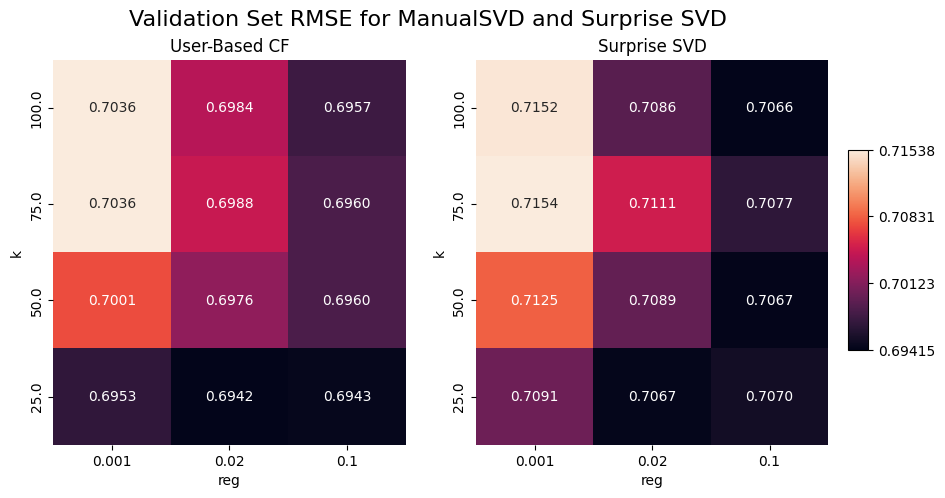

In [ ]:
fig, axes = plot_comparison_heatmap(grid_search, surprise_grid_search, "RMSE")
fig.suptitle("Validation Set RMSE for ManualSVD and Surprise SVD", fontsize=16)
axes[0].set_title("ManualSVD")
axes[1].set_title("Surprise SVD")

Text(0.5, 1.0, 'Surprise SVD')

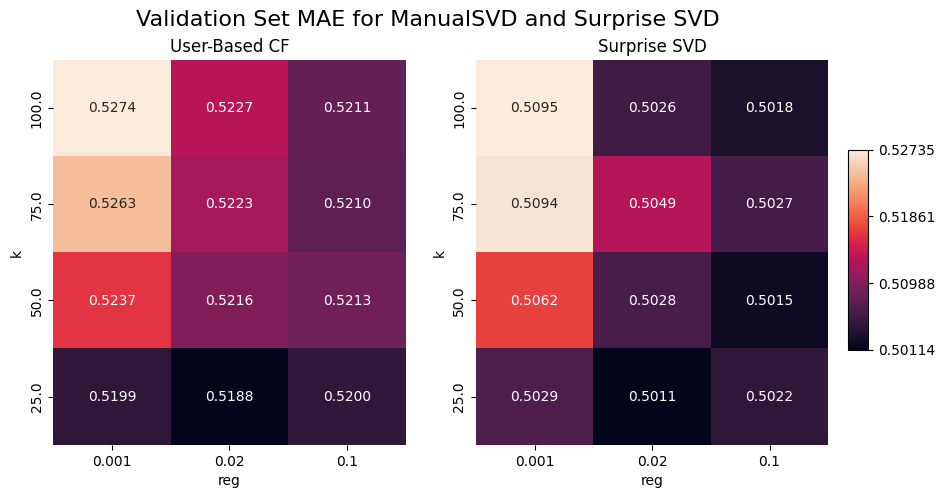

In [ ]:
fig, axes = plot_comparison_heatmap(grid_search, surprise_grid_search, "MAE")
fig.suptitle("Validation Set MAE for ManualSVD and Surprise SVD", fontsize=16)
axes[0].set_title("ManualSVD")
axes[1].set_title("Surprise SVD")

Text(0.5, 1.0, 'Surprise SVD')

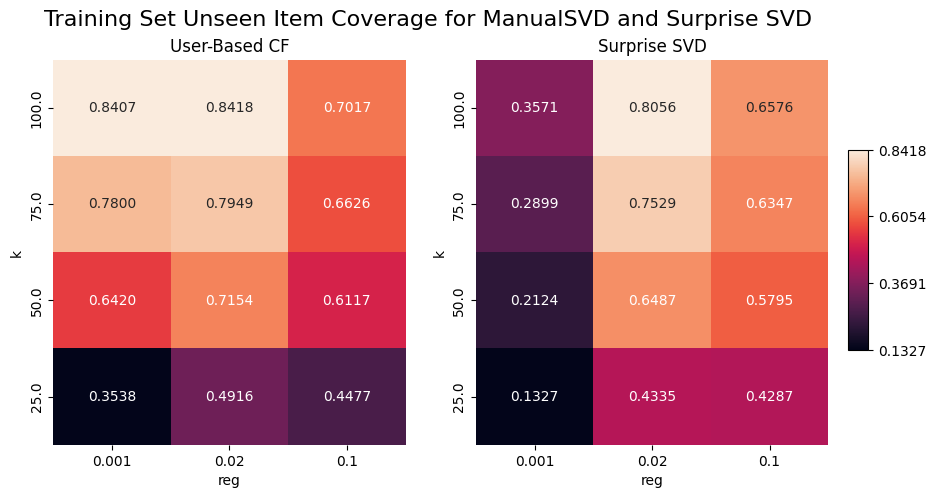

In [ ]:
fig, axes = plot_comparison_heatmap(grid_search, surprise_grid_search, "coverage")
fig.suptitle("Training Set Unseen Item Coverage for ManualSVD and Surprise SVD", fontsize=16)
axes[0].set_title("ManualSVD")
axes[1].set_title("Surprise SVD")

In [10]:
get_beer_data(baseline, models[7].get_top_N(N=10)[1000], item_encoder)

beer_name  \
                                                                 
beer_beerid                                                      
57440                        Michelob Ultra Dragon Fruit Peach   
24219                                        IJsbok (for SNAB)   
47071                           Double Kiltlifter (Batch 1000)   
51098                                                  Bristol   
4216                                        Fleishhacker Stout   
44058        Sea Monster (Blended/ Jack Daniel's Whisky Bar...   
56477                           Peg's G.O.O.D. Berliner Weisse   
32977                                              Jackson Wit   
37455                               Captain Cooker Manuka Beer   
70811                                                  Rye IPA   

                                        brewery_name  \
                                                       
beer_beerid                                            
57440                                 Anheuser-Busch   
24219               De Proefbrouwerij (bvba Andelot)   
47071                               Moylan's Brewery   
51098                     Microbrasserie Le Corsaire   
4216             Beach Chalet Brewery and Restaurant   
44058                  Ballast Point Brewing Company   
56477        Peg's Cantina & Brewpub / Cycle Brewing   
32977            Flatlander's Restaurant and Brewery   
37455               De Proefbrouwerij (bvba Andelot)   
70811                              Feral Brewing Co.   

                                      beer_style review_overall        \
                                                           mean count   
beer_beerid                                                             
57440                                Light Lager       1.970588    17   
24219                                    Eisbock       4.291667    12   
47071                     Scotch Ale / Wee Heavy       3.611111     9   
51098        Extra Special / Strong Bitter (ESB)       2.916667     6   
4216                              American Stout       3.600000     5   
44058           American Double / Imperial Stout       3.400000     5   
56477                         Berliner Weissbier       4.600000     5   
32977                                    Witbier       3.500000     4   
37455                       Herbed / Spiced Beer       3.500000     3   
70811                               American IPA       4.333333     3   

                      beer_abv  
                  std     mean  
beer_beerid                     
57440        0.819119      4.0  
24219        0.334279      9.3  
47071        1.083333     11.0  
51098        1.068488      4.8  
4216         0.418330      5.6  
44058        0.651920      7.0  
56477        0.418330      3.9  
32977        0.408248      5.2  
37455        0.000000      5.7  
70811        0.288675      7.4

In [11]:
baseline[baseline['user_idx'] == 1000]

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,user_idx,item_idx
1269613,203,Greene King / Morland Brewery,1315776992,4.0,3.5,3.5,BrewMaester,English Pale Ale,4.0,4.0,Old Speckled Hen,5.2,637,1000,393
172459,221,Desnoes & Geddes Limited,1315777791,3.5,3.0,3.5,BrewMaester,American Adjunct Lager,3.5,4.0,Red Stripe Jamaican Lager,4.7,689,1000,432
922322,75,Grupo Modelo S.A. de C.V.,1315956221,3.0,2.5,2.0,BrewMaester,American Adjunct Lager,3.0,3.5,Modelo Especial,4.4,1321,1000,811
1037448,100,McNeill's Brewery,1315955825,4.0,3.5,4.0,BrewMaester,English India Pale Ale (IPA),4.0,4.5,McNeill's Dead Horse IPA,5.7,1884,1000,1187
31053,1199,Founders Brewing Company,1315781841,4.5,3.5,4.0,BrewMaester,American IPA,4.5,4.5,Founders Centennial IPA,7.2,5441,1000,2988
568068,766,Heartland Brewery Union Square,1315955265,3.5,3.0,3.5,BrewMaester,American Adjunct Lager,3.0,3.0,Heartland Brewery Grateful Red Lager,5.7,14042,1000,6275
703928,695,Manayunk Brewery and Restaurant,1315782328,4.0,3.5,3.5,BrewMaester,American Double / Imperial IPA,3.5,4.0,Dreamin' Double IPA,8.5,18764,1000,7837
465742,392,Weyerbacher Brewing Co.,1315956055,4.5,4.5,4.0,BrewMaester,Pumpkin Ale,4.5,4.5,Imperial Pumpkin Ale,8.0,25880,1000,10039
92799,140,Sierra Nevada Brewing Co.,1315781513,4.5,4.0,4.5,BrewMaester,American IPA,4.5,4.0,Sierra Nevada Torpedo Extra IPA,7.2,30420,1000,11457
1238127,20766,Greenport Harbor Brewing Company,1315955418,3.5,3.5,3.0,BrewMaester,American Pale Ale (APA),3.5,4.0,Harbor Ale,5.3,52157,1000,18763
